# Задача 

Обучить кодировщик помещать похожие лица рядом.

# Решение

## Среда

In [32]:
#@title Библиотеки
import os
import sys
import random as random
import matplotlib.pyplot as plt 
import matplotlib.image as matimg
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from IPython.display import clear_output, Image as ImagePy 
from PIL import Image 
import imageio 
import time
import datetime
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing import image # для отрисовки изображения
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор

from tensorflow.keras import utils # загружаем утилиты кераса
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm 
import shutil

### Параметры

In [53]:
DATA_PATH = 'data' # основной каталог для сохранения и загрузки данных
SAVE_FIT = os.path.join(DATA_PATH, 'fit')
FACE_PATH = os.path.join(DATA_PATH, 'imgs') # каталог сохранения загрузки фото
COUNT_FACE = 100 # количество скачиваемых фото одного актера
NORM_PATH = os.path.join(DATA_PATH, 'norm') # каталог сохранения нормализованного фото
WEB_PATH = os.path.join(DATA_PATH, 'web') # каталог сохранения фото в формате webp
SHAPE_IN = (100, 100, 3)  # размер нормализации
SHAPE_WEB = (160, 160, 3)  # размер для сайта 
HIDDEN = 3 # размер скрытого пространства кодировщика
MARGIN = 1000 # ошибка расстояния сиамской сети
EPS = 600 # количество эпох финального обучения
BATCH = 32 # размер партий обучения
SIZE_DATASET = 7000 # финальный размер выборки 
VALID_SIZE = 0.2 # процент проверочных данных
TEST_SIZE = 0.2 # процент тестовых данных
COUNT_EXP = 1000 # кол-во экспортируемых фото 
PATH_EXP = os.path.join(DATA_PATH, 'fake')
FILE_EXP = os.path.join(DATA_PATH, 'fake.csv')

## Датасет

In [6]:
#@title Список актеров
with open('actors.json', 'r') as fp:
    dict_act = json.load(fp)
dict_act

{'women': ['Alicia Vikander',
  'Amy Adams',
  'Andie MacDowell',
  'Angelina Jolie',
  'Anne Hathaway',
  'Cameron Diaz',
  'Carey Mulligan',
  'Cate Blanchett',
  'Catherine Zeta-Jones',
  'Charlize Theron',
  'Claire Forlani',
  'Demi Moore',
  'Drew Barrymore',
  'Elizabeth Taylor',
  'Emma Stone',
  'Eva Mendes',
  'Frances McDormand',
  'Gwyneth Paltrow',
  'Halle Berry',
  'Hilary Swank',
  'Jennifer Aniston',
  'Jessica Biel',
  'Jessica Chastain',
  'Jodie Foster',
  'Julia Roberts',
  'Julianne Moore',
  'Juliette Binoche',
  'Kate Winslet',
  'Keira Knightley',
  'Kim Basinger',
  'Kirsten Dunst',
  'Kristin Scott Thomas',
  "Lupita Nyong'o",
  'Maggie Gyllenhaal',
  'Marion Cotillard',
  'Meg Ryan',
  'Megan Fox',
  'Melanie Laurent',
  'Meryl Streep',
  'Michelle Pfeiffer',
  'Milla Jovovich',
  'Naomi Watts',
  'Natalie Portman',
  'Natasha Henstridge',
  'Nicole Kidman',
  'Nina Dobrev',
  'Octavia Spencer',
  'Penélope Cruz',
  'Rachel McAdams',
  'Reese Witherspoon',
 

### Парсинг фото

In [5]:
filters = "+filterui:imagesize-large+filterui:color2-color+filterui:photo-photo+filterui:aspect-square+filterui:face-face"
for key in list(dict_act.keys()):
    print(key)
    for face in tqdm(dict_act[key]):
        os.system(f'python bbid.py -s "{face}" -o "{os.path.join(FACE_PATH, face)}" --filters {filters} --limit {COUNT_FACE}')

women


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [17:18<00:00, 17.03s/it]


men


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [19:53<00:00, 16.13s/it]


### Нормализация

#### Обрезка и расшиерние краев

In [8]:
#@title Обрезка краев
def crop_img(i, h=320, w=320):
    k = i.size[0]/i.size[1] # разница высоты и ширины
    i = i.resize((int(w*k) if k > 1 else w, int(h/k) if k < 1 else h))
    x1, y1 = (w + (i.size[0]-w)//2, 0) if k > 1 else (0, h+(i.size[1]-h)//2)
    x2, y2 = ((i.size[0]-w)//2, h) if k > 1 else (w, (i.size[1]-h)//2)
    i = i.crop(([x1,x2][k>1], [y1,y2][k<=1], [x1,x2][k<=1], [y1,y2][k>1]))
    return np.array(i)
#@title Расширение краев
def extend_img(i, h=320, w=320):
    k = i.size[0]/i.size[1] # разница высоты и ширины
    bg = Image.new('RGB', (i.size[k<1], i.size[k<1]), (0, 0, 0))
    img_w, img_h = i.size
    bg_w, bg_h = bg.size
    offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
    bg.paste(i, offset)
    i = bg.resize((w, h))
    return np.array(i)

#### Сохранение фото

In [ ]:
#@title Сохранение фото
if not os.path.exists(NORM_PATH): os.mkdir(NORM_PATH)
i = 0
for key in list(dict_act.keys()):
    for face in dict_act[key]:
        path = FACE_PATH + os.path.sep + face
        imgs_fnames = os.listdir(path) # получим список изображений 
        for j, fname in tqdm(enumerate(imgs_fnames)): 
            fname = os.path.join(path, fname)
            try:
                arr = Image.open(fname)
                k = arr.size[0]/arr.size[1] # разница высоты и ширины
                if k < 0.9 or k > 1.1:
                    norm = crop_img(arr, *SHAPE_IN[:2])
                    web  = crop_img(arr, *SHAPE_WEB[:2])
                else:
                    norm = extend_img(arr, *SHAPE_IN[:2])
                    web  = crop_img(arr, *SHAPE_WEB[:2])
                
                im = Image.fromarray(norm)
                dname = os.path.join(NORM_PATH, face)
                if not os.path.exists(dname): os.mkdir(dname)
                im.save(dname + os.sep+ f'{j:03d}.jpg')
                
                im = Image.fromarray(web)
                dname = os.path.join(WEB_PATH, face)
                if not os.path.exists(dname): os.mkdir(dname)
                im.save(dname + os.sep + f'{j:03d}.webp', format="webp") 

                i += 1
            except Exception as er:
                print(er)
print('total count face', i)

41it [00:01, 31.14it/s]

cannot identify image file 'data\\imgs\\Alicia Vikander\\Alicia-Vikander'


97it [00:04, 24.15it/s]
49it [00:01, 36.37it/s]

cannot identify image file 'data\\imgs\\Amy Adams\\Amy-Adams'


100it [00:03, 25.95it/s]
54it [00:01, 24.68it/s]

cannot identify image file 'data\\imgs\\Andie MacDowell\\Andie-MacDowell'


100it [00:03, 28.26it/s]
12it [00:00, 23.77it/s]

cannot write mode RGBA as JPEG


45it [00:01, 29.13it/s]

cannot write mode RGBA as JPEG


100it [00:04, 22.98it/s]
99it [00:04, 20.25it/s]
100it [00:03, 28.99it/s]
51it [00:01, 39.09it/s]

cannot identify image file 'data\\imgs\\Carey Mulligan\\Carey-Mulligan'


99it [00:03, 28.39it/s]
100it [00:04, 23.28it/s]
98it [00:03, 28.99it/s]
15it [00:00, 25.82it/s]C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
88it [00:03, 28.58it/s]
42it [00:00, 46.97it/s]

cannot identify image file 'data\\imgs\\Claire Forlani\\Claire-Forlani'


91it [00:02, 33.97it/s]

cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG


100it [00:02, 38.74it/s]
29it [00:01, 27.01it/s]

cannot identify image file 'data\\imgs\\Demi Moore\\Demi-Moore'


73it [00:02, 26.77it/s]


cannot write mode RGBA as JPEG


49it [00:01, 24.91it/s]

cannot identify image file 'data\\imgs\\Drew Barrymore\\Drew-Barrymore'


100it [00:04, 24.14it/s]
49it [00:01, 28.19it/s]

cannot write mode RGBA as JPEG


100it [00:03, 29.62it/s]
100it [00:04, 24.21it/s]
99it [00:03, 31.65it/s]
33it [00:01, 27.26it/s]
100it [00:03, 25.73it/s]
30it [00:01, 25.30it/s]

cannot write mode RGBA as JPEG


100it [00:04, 20.99it/s]
55it [00:01, 32.15it/s]

cannot identify image file 'data\\imgs\\Hilary Swank\\Hilary-Swank'


100it [00:03, 30.17it/s]
55it [00:02, 26.63it/s]

cannot identify image file 'data\\imgs\\Jennifer Aniston\\Jennifer-Aniston'


100it [00:04, 21.32it/s]
100it [00:03, 26.73it/s]
100it [00:03, 28.46it/s]
55it [00:01, 31.59it/s]

cannot identify image file 'data\\imgs\\Jodie Foster\\Jodie-Foster'


100it [00:03, 28.37it/s]
5it [00:00, 20.22it/s]

cannot write mode RGBA as JPEG


63it [00:02, 34.92it/s]

cannot identify image file 'data\\imgs\\Julia Roberts\\Julia-Roberts'


100it [00:05, 19.95it/s]
63it [00:02, 38.63it/s]

cannot identify image file 'data\\imgs\\Julianne Moore\\Julianne-Moore'
cannot identify image file 'data\\imgs\\Julianne Moore\\Julianne-Moore---The-Hunger-Games'


76it [00:02, 33.45it/s]

cannot write mode RGBA as JPEG


100it [00:03, 31.20it/s]
79it [00:02, 35.76it/s]
82it [00:03, 29.16it/s]

cannot write mode RGBA as JPEG


100it [00:03, 27.85it/s]
30it [00:01, 28.25it/s]

cannot write mode RGBA as JPEG


100it [00:03, 25.62it/s]
22it [00:00, 39.28it/s]

cannot write mode RGBA as JPEG


100it [00:02, 40.90it/s]
100it [00:04, 24.93it/s]
69it [00:02, 32.55it/s]

cannot identify image file 'data\\imgs\\Kristin Scott Thomas\\Kristin-Scott-Thomas'


98it [00:02, 32.98it/s]
100it [00:03, 26.94it/s]
54it [00:01, 32.83it/s]

cannot identify image file 'data\\imgs\\Maggie Gyllenhaal\\Maggie-Gyllenhaal'


99it [00:03, 29.68it/s]
100it [00:02, 33.52it/s]
91it [00:03, 29.90it/s]
100it [00:03, 27.60it/s]
65it [00:01, 30.02it/s]

cannot write mode RGBA as JPEG


100it [00:02, 33.55it/s]
46it [00:01, 24.56it/s]
100it [00:03, 33.29it/s]
32it [00:00, 34.45it/s]

cannot write mode RGBA as JPEG


100it [00:02, 33.54it/s]
53it [00:01, 26.43it/s]

cannot identify image file 'data\\imgs\\Naomi Watts\\Naomi-Watts'


100it [00:03, 31.52it/s]
50it [00:01, 27.48it/s]

cannot identify image file 'data\\imgs\\Natalie Portman\\https'


85it [00:03, 26.86it/s]

cannot write mode RGBA as JPEG


100it [00:03, 26.28it/s]
100it [00:02, 36.61it/s]
93it [00:03, 35.90it/s]

cannot write mode RGBA as JPEG


100it [00:03, 30.73it/s]
98it [00:03, 26.25it/s]

cannot write mode RGBA as JPEG


100it [00:03, 27.54it/s]
100it [00:02, 37.87it/s]
18it [00:00, 31.64it/s]

cannot write mode RGBA as JPEG


26it [00:00, 35.30it/s]

cannot write mode RGBA as JPEG


42it [00:01, 40.00it/s]

cannot write mode RGBA as JPEG


100it [00:03, 31.48it/s]
100it [00:03, 28.64it/s]


cannot write mode RGBA as JPEG


50it [00:02, 24.59it/s]

cannot identify image file 'data\\imgs\\Reese Witherspoon\\Reese-Witherspoon'


100it [00:04, 23.02it/s]
100it [00:03, 29.58it/s]
100it [00:03, 29.62it/s]
90it [00:03, 32.09it/s]

cannot write mode RGBA as JPEG


100it [00:03, 26.69it/s]
87it [00:03, 18.64it/s]

cannot write mode RGBA as JPEG


100it [00:04, 21.97it/s]
100it [00:03, 26.85it/s]
100it [00:03, 28.16it/s]
100it [00:03, 30.38it/s]
53it [00:01, 42.32it/s]

cannot identify image file 'data\\imgs\\Vera Farmiga\\Vera-Farmiga'


65it [00:01, 41.86it/s]
48it [00:02, 16.45it/s]
100it [00:04, 24.72it/s]
100it [00:04, 24.90it/s]
100it [00:04, 24.93it/s]
100it [00:02, 38.46it/s]
99it [00:02, 37.26it/s]
100it [00:04, 22.75it/s]
70it [00:01, 47.88it/s]

cannot write mode RGBA as JPEG


100it [00:02, 36.06it/s]
3it [00:00, 27.75it/s]

cannot write mode RGBA as JPEG


100it [00:02, 34.57it/s]
100it [00:02, 33.34it/s]
99it [00:02, 42.67it/s]
80it [00:01, 42.82it/s]
100it [00:03, 32.27it/s]
100it [00:03, 25.71it/s]
42it [00:01, 33.67it/s]
43it [00:01, 28.42it/s]
44it [00:01, 37.05it/s]

cannot write mode RGBA as JPEG


100it [00:03, 31.60it/s]
100it [00:02, 38.94it/s]
100it [00:03, 32.00it/s]
100it [00:02, 37.33it/s]
24it [00:00, 39.15it/s]

cannot write mode RGBA as JPEG


100it [00:02, 37.28it/s]
77it [00:02, 37.96it/s]
72it [00:02, 32.85it/s]

cannot write mode RGBA as JPEG


94it [00:02, 32.50it/s]

cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG


100it [00:03, 32.67it/s]
17it [00:00, 27.03it/s]

cannot write mode RGBA as JPEG


100it [00:03, 32.83it/s]
100it [00:02, 40.45it/s]
39it [00:01, 33.88it/s]

cannot write mode RGBA as JPEG


100it [00:02, 35.27it/s]
100it [00:03, 30.47it/s]
100it [00:02, 35.21it/s]
100it [00:03, 32.32it/s]
100it [00:02, 37.94it/s]
100it [00:03, 28.50it/s]
100it [00:02, 33.62it/s]
100it [00:03, 28.56it/s]
100it [00:02, 40.94it/s]
100it [00:02, 40.73it/s]
100it [00:03, 32.85it/s]
100it [00:02, 35.32it/s]
65it [00:02, 34.25it/s]

cannot write mode RGBA as JPEG


100it [00:03, 32.53it/s]


cannot write mode RGBA as JPEG


100it [00:02, 33.40it/s]
80it [00:02, 34.98it/s]

cannot write mode RGBA as JPEG


100it [00:03, 32.61it/s]
61it [00:01, 33.76it/s]

cannot identify image file 'data\\imgs\\Jeff Bridges\\https'


97it [00:02, 39.45it/s]

cannot write mode RGBA as JPEG


100it [00:02, 36.86it/s]
99it [00:02, 34.47it/s]
100it [00:03, 30.29it/s]
71it [00:01, 41.84it/s]

cannot write mode RGBA as JPEG


100it [00:02, 40.59it/s]
33it [00:00, 33.33it/s]
76it [00:02, 30.64it/s]

cannot write mode RGBA as JPEG


100it [00:02, 37.07it/s]
44it [00:01, 33.47it/s]

cannot write mode RGBA as JPEG


100it [00:03, 30.39it/s]
100it [00:03, 31.27it/s]
100it [00:06, 15.68it/s]
24it [00:01, 26.76it/s]

cannot write mode RGBA as JPEG


100it [00:03, 26.15it/s]
100it [00:03, 26.02it/s]
100it [00:07, 13.63it/s]
100it [00:03, 30.09it/s]
43it [00:02, 19.75it/s]
100it [00:04, 23.36it/s]

cannot write mode RGBA as JPEG



100it [00:02, 36.08it/s]
27it [00:01, 23.54it/s]
100it [00:03, 25.60it/s]


cannot write mode RGBA as JPEG


100it [00:04, 21.44it/s]
44it [00:01, 33.13it/s]
77it [00:02, 31.94it/s]

cannot write mode RGBA as JPEG



50it [00:01, 38.35it/s]

cannot write mode RGBA as JPEG


100it [00:03, 33.01it/s]
24it [00:01, 26.33it/s]

cannot write mode RGBA as JPEG


51it [00:01, 39.40it/s]

cannot write mode RGBA as JPEG


100it [00:03, 31.07it/s]
46it [00:02, 16.70it/s]

cannot write mode RGBA as JPEG


100it [00:05, 17.47it/s]
89it [00:02, 33.06it/s]
23it [00:00, 43.56it/s]

cannot write mode RGBA as JPEG


100it [00:03, 32.46it/s]
100it [00:03, 30.90it/s]
100it [00:02, 38.05it/s]
100it [00:02, 35.68it/s]
100it [00:02, 37.55it/s]
44it [00:01, 33.23it/s]

cannot write mode RGBA as JPEG


94it [00:03, 29.22it/s]
73it [00:02, 41.74it/s]

### Ранжировка выборки     

#@title Ранжировка выборки        
def shffle_dir_dataset():  
    if os.path.isfile(data_list):
        f = input('Список уже сформирован, 1 - заново?: ')
        if '1' == f:
            os.remove(data_list)
        else: return
    data_list = os.path.join(DATA_PATH, 'data.json')        
    flds = os.listdir(NORM_PATH)
    count = len(flds)
    rnd_fld = random.choices(flds, k=int(TEST_SIZE*count))
    data = {'train': [], 'test': []}
    for fld in flds:
        if fld in rnd_fld:
            data['test'].append(fld)
        else:
            data['train'].append(fld)
    with open(data_list, 'w') as fp:
        json.dump(data, fp)
    return data
shffle_dir_dataset()

### Выборки сиамской сети

In [10]:
#@title Выборки сиамской сети

def process_img(files, y):
    img_a = tf.io.read_file(files[0])
    img_b = tf.io.read_file(files[1])
    img_a = tf.image.decode_jpeg(img_a, channels=3)
    img_b = tf.image.decode_jpeg(img_b, channels=3)
    img_a.set_shape(SHAPE_IN)
    img_b.set_shape(SHAPE_IN)
    img_a = tf.image.convert_image_dtype(img_a, tf.float32)
    img_b = tf.image.convert_image_dtype(img_b, tf.float32)
    print(img_a.shape, img_b.shape)
    return (img_a, img_b), y

def get_big_data(batch=BATCH, valid_size=VALID_SIZE):
    with open(os.path.join(DATA_PATH, 'data.json'), 'r') as fp:
        train_act = json.load(fp)['train']
    list_dirs = [os.path.join(NORM_PATH, a) for a in train_act]    
    len_dname = len(list_dirs)
   
    X, Y = [], []
    
    for i in range(len_dname):
        file_lst = os.listdir(list_dirs[i])
        next_dir = list_dirs[0] if i == len_dname - 1 else list_dirs[i+1]
        next_lst = os.listdir(next_dir)
        half_len = len(file_lst)//2
        for j, (a, b) in enumerate(zip(file_lst[:half_len], file_lst[half_len:])):
            a = os.path.join(list_dirs[i], a)
            b = os.path.join(list_dirs[i], b)
            if os.path.getsize(a) == 0 or os.path.getsize(a) is None: continue
            if os.path.getsize(b) != 0 or os.path.getsize(b) is not None: 
                X.append((a, b))
                Y.append(1.)    
            c = next_lst[j] if j < len(next_lst) else None
            if c is not None:
                c = os.path.join(next_dir, c)
                if os.path.getsize(c) == 0 or os.path.getsize(c) is None: continue
                X.append((a, c))
                Y.append(0.) 
                X.append((b, c))
                Y.append(0.)                
        
    
    X = np.array(X)
    Y = np.array(Y)
    
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=valid_size, shuffle=True, random_state=42) 
    
     
    valid_data  = tf.data.Dataset.from_tensor_slices((x_valid, 
                                                  y_valid))
  
  
    train_data = tf.data.Dataset.from_tensor_slices((x_train, 
                                                  y_train))


    train_gen = train_data.map(lambda x, y: process_img(x, y)).batch(batch)
    valid_gen = valid_data.map(lambda x, y: process_img(x, y)).batch(batch)

    print('All', X.shape, 'true', Y[Y==1].shape, 'train',  x_train.shape, 'valid', x_valid.shape)
    return train_gen, valid_gen

train_gen, valid_gen = get_big_data()

(100, 100, 3) (100, 100, 3)
(100, 100, 3) (100, 100, 3)
All (15393, 2) true (5163,) train (12314, 2) valid (3079, 2)


## Модель

### Encoder

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 conv2d_57 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 conv2d_59 (Conv2D)          (None, 44, 44, 128)       147584    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 22, 22, 128)      0         
 g2D)                                                      

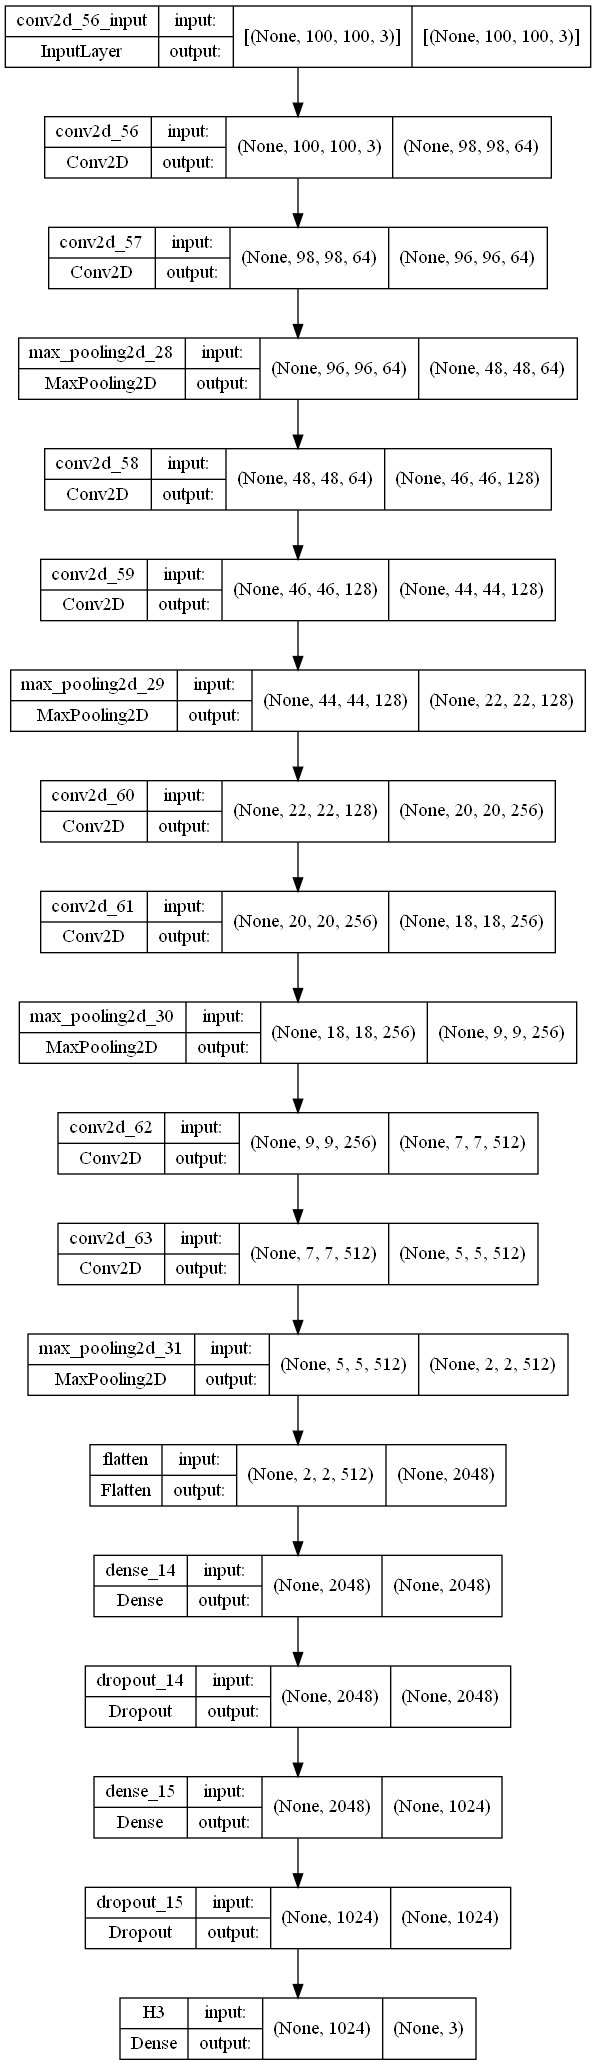

In [35]:
#@title Encoder
def get_encoder(act='relu', dim=3, s=1, k2=5e-4):  
    return Sequential([
      
     Conv2D(64,  (3, 3), activation=act,  input_shape=SHAPE_IN, strides=s, kernel_regularizer=l2(k2)),
     Conv2D(64,  (3, 3), activation=act,  strides=s, kernel_regularizer=l2(k2)),
     MaxPooling2D(),
     Conv2D(128,  (3, 3), activation=act,  strides=s, kernel_regularizer=l2(k2)),
     Conv2D(128,  (3, 3), activation=act,  strides=s, kernel_regularizer=l2(k2)),
     MaxPooling2D(), 
     Conv2D(256,  (3, 3), activation=act,  strides=s, kernel_regularizer=l2(k2)),
     Conv2D(256,  (3, 3), activation=act,  strides=s, kernel_regularizer=l2(k2)),
     MaxPooling2D(), 
     Conv2D(512,  (3, 3), activation=act,  strides=s, kernel_regularizer=l2(k2)),
     Conv2D(512,  (3, 3), activation=act,  strides=s, kernel_regularizer=l2(k2)),
     MaxPooling2D(), 
     Flatten(name='flatten'), 
     Dense(2048, activation=act),
     Dropout(0.5),
     Dense(1024, activation=act),
     Dropout(0.5),
     Dense(dim, name='H3'),                    
    ], name='encoder')

m = get_encoder()
print(m.summary())
utils.plot_model(m, dpi=96, show_shapes=True)

### Сиамская нейронная сеть

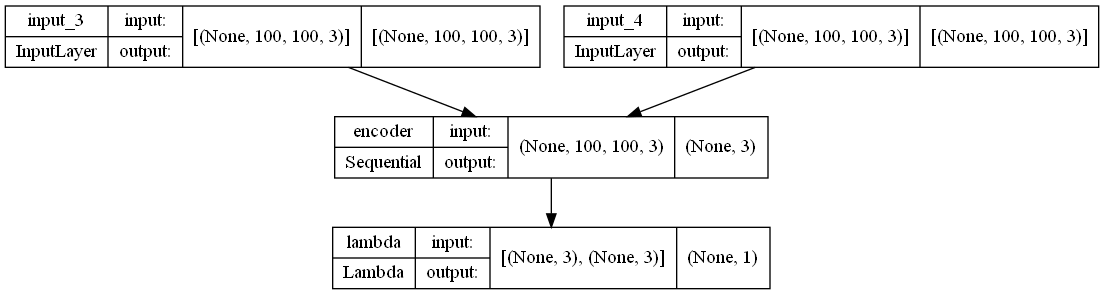

In [14]:
#@title Сиамская нейронная сеть

def get_siam(act='relu', dim=3, lr=0.001):

    img_a = Input(shape=SHAPE_IN)
    img_b = Input(shape=SHAPE_IN)

    encoder = get_encoder(act=act, dim=dim)

    vecs_a = encoder(img_a)
    vecs_b = encoder(img_b)
    
    def euclidean_distance(vects):
        x, y = vects
        return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

    def eucl_dist_output_shape(shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)

    distance = Lambda(euclidean_distance, 
                    output_shape=eucl_dist_output_shape)([vecs_a, vecs_b])

    def loss_siam(distance):
        def contrastive_loss(y_true, y_pred):
            loss = K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(float(MARGIN) - y_pred, 0)))
            return loss
        return contrastive_loss
    
    model = Model([img_a, img_b], distance)

    
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss_siam(distance))

    
    return model, encoder

utils.plot_model(get_siam()[0], dpi=96, show_shapes=True)

## Обучение

### Колбэки

In [56]:
#@title Колбэки

class SaveLoss(Callback):
    
    def on_train_begin(self, logs=None):
        self.loss = None
        print(f'Begin train {self.name}')
        if not os.path.isdir(os.path.join(SAVE_FIT, f'{self.name}')):
            os.mkdir(os.path.join(SAVE_FIT, f'{self.name}'))
        
    def on_epoch_begin(self, epoch, logs): 
        self.e = epoch
        
    def on_epoch_end(self, epoch, logs):
        if self.loss is not None:
            if self.loss > logs['val_loss']:
                self.loss = logs['val_loss']
                self.model.save_weights(os.path.join(SAVE_FIT, f'{self.name}', f'e{self.e}_{self.loss}.hdf5'))
        else:
            self.loss = logs['val_loss']
        logs['lr']=self.model.optimizer.learning_rate.numpy()
        with open(self.floss, 'a') as f:
              f.write(f'{epoch},%(loss)s,%(val_loss)s,%(lr)s\n' % logs) 

def call_back (name):

    save = SaveLoss()
    save.name = name
    save.floss = DATA_PATH + os.path.sep + f'{name}.csv'
    if os.path.exists(save.floss):
        os.remove(save.floss)
    return [  save,
              # Динамический lr
              # ReduceLROnPlateau(monitor='val_loss', factor=0.5,# Колбэк дообучения
              #                  patience=10, min_lr=0.0000000001, verbose=0), 
              # Сохранение лучших весов
              ModelCheckpoint(monitor='val_loss', 
                              verbose=0, 
                              filepath = DATA_PATH+os.path.sep+f'{name}.hdf5', 
                              save_best_only=True, 
                              save_weights_only=True)
           ]



### Этапное обучение

In [21]:
for i, (lr, eps) in enumerate(((0.0001, 500), (0.00005, 600), (0.00001, 1000))):
    print(f'Этап обучения №{i+3}')
    siam, enc = get_siam(lr=lr)
    if os.path.isfile(DATA_PATH + os.sep + f'statlr_{i+2}.hdf5'): 
        siam.load_weights(DATA_PATH + os.sep + f'statlr_{i+2}.hdf5')
    h = siam.fit(train_gen, epochs=eps, 
             callbacks=call_back(f'statlr_{i+3}'), validation_data=valid_gen)

Этап обучения №3
Epoch 1/500
385/385 [==============================] - 161s 369ms/step - loss: 287235.8125 - val_loss: 663164.0625 - lr: 1.0000e-04
Epoch 2/500
385/385 [==============================] - 138s 357ms/step - loss: 292143.2188 - val_loss: 663184.4375 - lr: 1.0000e-04
Epoch 3/500
385/385 [==============================] - 137s 357ms/step - loss: 291062.3125 - val_loss: 663174.5625 - lr: 1.0000e-04
Epoch 4/500
385/385 [==============================] - 138s 357ms/step - loss: 292674.0312 - val_loss: 663149.8125 - lr: 1.0000e-04
Epoch 5/500
385/385 [==============================] - 137s 357ms/step - loss: 292285.4688 - val_loss: 663189.0000 - lr: 1.0000e-04
Epoch 6/500
385/385 [==============================] - 137s 357ms/step - loss: 290327.9375 - val_loss: 663181.1875 - lr: 1.0000e-04
Epoch 7/500
385/385 [==============================] - 137s 357ms/step - loss: 286111.0312 - val_loss: 663186.1250 - lr: 1.0000e-04
Epoch 8/500
385/385 [==============================] - 137s

KeyboardInterrupt: 

### График обучения

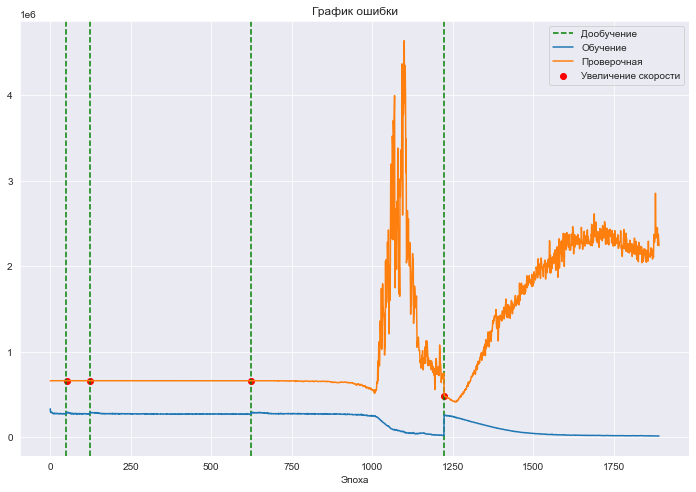

In [25]:
#@title График обучения
def show_loss(*fnames):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,8))
    loss, vall, x, lr = [], [], [], None
    e = 0
    for i, fname in enumerate(fnames):
        
        if i > 0: 
            if i == 1: 
                plt.axvline(len(loss), label='Дообучение', c='g', linestyle='dashed')
            else:
                plt.axvline(len(loss), c='g', linestyle='dashed')
        with open(fname, 'r') as f:
            for v in f:
                e += 1
                logs = v.split(',')
                loss.append(float(logs[1]))
                vall.append(float(logs[2]))
                if lr is None: 
                    lr = float(logs[3]) 
                else:
                    if lr - float(logs[3]) != 0:
                        x.append(e)
                    lr = float(logs[3])
    plt.title(f'График ошибки')
    plt.plot(loss, label='Обучение')
    plt.plot(vall, label='Проверочная')
    plt.xlabel('Эпоха')
    y = [vall[i] for i in x]
    plt.scatter(x, y, label='Увеличение скорости', c='red')
    plt.legend()
    plt.show()

show_loss(*[DATA_PATH + os.path.sep + f'statlr_{i}.csv' for i in range(1, 6)])

### Этап 3

In [59]:
siam, enc = get_siam(lr=lr)
siam.load_weights(DATA_PATH + os.sep + f'statlr_3.hdf5')
h = siam.fit(train_gen, epochs=500, callbacks=call_back(f'statlr_3_l2'), validation_data=valid_gen)

Begin train statlr_3_l2
Epoch 1/500
385/385 [==============================] - 141s 365ms/step - loss: 289045.5312 - val_loss: 663172.1250 - lr: 1.0000e-05
Epoch 2/500
385/385 [==============================] - 140s 364ms/step - loss: 287109.7500 - val_loss: 663175.3125 - lr: 1.0000e-05
Epoch 3/500
385/385 [==============================] - 140s 365ms/step - loss: 289683.9688 - val_loss: 663169.1875 - lr: 1.0000e-05
Epoch 4/500
385/385 [==============================] - 140s 364ms/step - loss: 288681.6562 - val_loss: 663174.3750 - lr: 1.0000e-05
Epoch 5/500
385/385 [==============================] - 140s 364ms/step - loss: 292014.6250 - val_loss: 663173.9375 - lr: 1.0000e-05
Epoch 6/500
385/385 [==============================] - 140s 364ms/step - loss: 286180.2500 - val_loss: 663176.2500 - lr: 1.0000e-05
Epoch 7/500
385/385 [==============================] - 140s 364ms/step - loss: 285234.7500 - val_loss: 663181.6875 - lr: 1.0000e-05
Epoch 8/500
385/385 [==============================]

### Этап 4

In [61]:
h = siam.fit(train_gen, epochs=2000, 
             callbacks=call_back(f'statlr_4_l2'), 
             validation_data=valid_gen)

Begin train statlr_4_l2
Epoch 1/2000
385/385 [==============================] - 142s 368ms/step - loss: 274586.5625 - val_loss: 642819.4375 - lr: 1.0000e-05
Epoch 2/2000
385/385 [==============================] - 251s 652ms/step - loss: 276682.6875 - val_loss: 642055.6250 - lr: 1.0000e-05
Epoch 3/2000
385/385 [==============================] - 140s 362ms/step - loss: 274937.9375 - val_loss: 643150.7500 - lr: 1.0000e-05
Epoch 4/2000
385/385 [==============================] - 139s 362ms/step - loss: 274752.3125 - val_loss: 642928.5625 - lr: 1.0000e-05
Epoch 5/2000
385/385 [==============================] - 139s 362ms/step - loss: 277698.8438 - val_loss: 643891.0625 - lr: 1.0000e-05
Epoch 6/2000
385/385 [==============================] - 139s 362ms/step - loss: 275662.7500 - val_loss: 643390.8125 - lr: 1.0000e-05
Epoch 7/2000
385/385 [==============================] - 139s 362ms/step - loss: 279314.7188 - val_loss: 644477.4375 - lr: 1.0000e-05
Epoch 8/2000
385/385 [=======================

### Этап 5

In [67]:
siam, enc = get_siam(lr=1.0e-06)
siam.load_weights(os.path.join(SAVE_FIT, 'statlr_4_l2', 'e1086_382144.96875.hdf5'))
h = siam.fit(train_gen, epochs=1000, 
             callbacks=call_back(f'statlr_5_l2'), 
             validation_data=valid_gen)

Begin train statlr_5_l2
Epoch 1/1000
385/385 [==============================] - 151s 365ms/step - loss: 217329.0312 - val_loss: 387633.8438 - lr: 1.0000e-06
Epoch 2/1000
385/385 [==============================] - 140s 364ms/step - loss: 218802.7812 - val_loss: 387049.8125 - lr: 1.0000e-06
Epoch 3/1000
385/385 [==============================] - 144s 373ms/step - loss: 217593.6406 - val_loss: 388264.6875 - lr: 1.0000e-06
Epoch 4/1000
385/385 [==============================] - 147s 382ms/step - loss: 218425.4688 - val_loss: 387169.5625 - lr: 1.0000e-06
Epoch 5/1000
385/385 [==============================] - 140s 364ms/step - loss: 217450.5469 - val_loss: 386987.9688 - lr: 1.0000e-06
Epoch 6/1000
385/385 [==============================] - 216s 561ms/step - loss: 217818.7812 - val_loss: 389025.4688 - lr: 1.0000e-06
Epoch 7/1000
385/385 [==============================] - 140s 364ms/step - loss: 216698.5312 - val_loss: 387401.5938 - lr: 1.0000e-06
Epoch 8/1000
385/385 [=======================

### Этап 6

In [69]:
siam, enc = get_siam(lr=1.0e-07)
siam.load_weights(os.path.join(SAVE_FIT, 'statlr_5_l2', 'e4_386987.96875.hdf5'))
h = siam.fit(train_gen, epochs=500, 
             callbacks=call_back(f'statlr_6_l2'), 
             validation_data=valid_gen)

Begin train statlr_6_l2
Epoch 1/500
385/385 [==============================] - 142s 365ms/step - loss: 219448.0312 - val_loss: 386537.0938 - lr: 1.0000e-07
Epoch 2/500
385/385 [==============================] - 140s 365ms/step - loss: 218505.5625 - val_loss: 386112.9062 - lr: 1.0000e-07
Epoch 3/500
385/385 [==============================] - 140s 365ms/step - loss: 220841.9688 - val_loss: 385826.4688 - lr: 1.0000e-07
Epoch 4/500
385/385 [==============================] - 140s 363ms/step - loss: 218058.1719 - val_loss: 385750.1250 - lr: 1.0000e-07
Epoch 5/500
385/385 [==============================] - 139s 362ms/step - loss: 219593.6719 - val_loss: 385515.8438 - lr: 1.0000e-07
Epoch 6/500
385/385 [==============================] - 139s 362ms/step - loss: 216838.2344 - val_loss: 385591.8750 - lr: 1.0000e-07
Epoch 7/500
385/385 [==============================] - 139s 362ms/step - loss: 219767.2969 - val_loss: 385421.1250 - lr: 1.0000e-07
Epoch 8/500
385/385 [==============================]

### Этап 7

In [ ]:
siam, enc = get_siam(lr=1.0e-08)
siam.load_weights(os.path.join(SAVE_FIT, 'statlr_6_l2', 'e25_385367.8125.hdf5'))
h = siam.fit(train_gen, epochs=100, 
             callbacks=call_back(f'statlr_7_l2'), 
             validation_data=valid_gen)

Begin train statlr_7_l2
Epoch 1/100
385/385 [==============================] - 142s 366ms/step - loss: 218585.1719 - val_loss: 385374.8125 - lr: 1.0000e-08
Epoch 2/100
385/385 [==============================] - 140s 365ms/step - loss: 218232.0312 - val_loss: 385372.7188 - lr: 1.0000e-08
Epoch 3/100
385/385 [==============================] - 140s 364ms/step - loss: 217316.1250 - val_loss: 385366.9375 - lr: 1.0000e-08
Epoch 4/100
385/385 [==============================] - 140s 364ms/step - loss: 216792.6875 - val_loss: 385380.3125 - lr: 1.0000e-08
Epoch 5/100
385/385 [==============================] - 140s 364ms/step - loss: 217672.9844 - val_loss: 385380.5938 - lr: 1.0000e-08
Epoch 6/100
385/385 [==============================] - 140s 364ms/step - loss: 216536.0781 - val_loss: 385387.8438 - lr: 1.0000e-08
Epoch 7/100
385/385 [==============================] - 140s 364ms/step - loss: 217852.1406 - val_loss: 385391.0312 - lr: 1.0000e-08
Epoch 8/100
385/385 [==============================]

### Общий график

In [ ]:
h = [DATA_PATH + os.sep + f'statlr_{i}.csv' for i in range(1, 4)]
h += [DATA_PATH + os.sep + f'statlr_3_l2.csv']
h += [DATA_PATH + os.sep + f'statlr_4_l2.csv']
h += [DATA_PATH + os.sep + f'statlr_5_l2.csv']
h += [DATA_PATH + os.sep + f'statlr_6_l2.csv']
h += [DATA_PATH + os.sep + f'statlr_7_l2.csv']
show_loss(*h)

##  Экспорт

 ### Конвертация модели в с++

In [27]:
#@title Конвертация модели в с++
from keras2cpp import export_model
my_model =  DATA_PATH + os.sep + 'my.model'
export_model(enc, my_model)

### Тест предсказания с с++

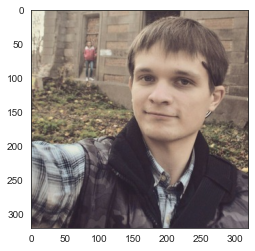

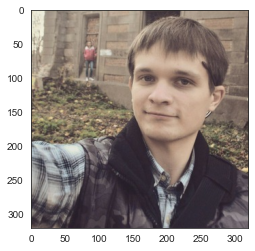

python: [[97.73354   -2.6821923 58.142017 ]]
keras2cpp data\my.model data\test.npy
c++: 


1

In [25]:
#@title Тест предсказания с с++
fname = 'C:\\Users\\User\\Desktop\\i99QImnBxBCkQysBLX61ECM2GHBWjhEHJdwGV_1pSMPCpRqfRMj2IYcPO7Ls4VKhJaUSxvzwV_gjfk8rEjxMJ2yMmo_cA3OUPjNr24UtvP41VjEL18ELs0ya2gHh5Jq9R2-omZ1-29x_ze4RQWOnH6xM8F9xK4Ozqmxt_THxLq0A5Mhbf6ICsASfEytrmK_dB8WBOiwLp428s1bTTJPEvOFtq.jpg'
test_npy = DATA_PATH + os.path.sep+ 'test'
arr = Image.open(fname)
arr = arr.convert('RGB')
sns.set_style('white')
plt.imshow(arr)
plt.show()

k = arr.size[0]/arr.size[1] 
if k <= 0.9 or k >= 1.1:
    x = crop_img(arr)
else:
    x = extend_img(arr)
x = x/255.
np.save(test_npy, x)
    
x = np.load(f'{test_npy}.npy')
plt.imshow(x)
plt.show()

x.resize(1, *SHAPE_IN)
print('python:', enc.predict(x)) 

cmd = f'keras2cpp {my_model} {test_npy}.npy'
print(cmd)
process = os.popen(cmd)
print('c++:', process.read())
process.close()            

### Экспорт тестовых фото

In [59]:
#@title Экспорт тестовых фото
if os.path.isfile(FILE_EXP):
    os.remove(FILE_EXP)
    
if not os.path.isdir(PATH_EXP):  
    os.mkdir(PATH_EXP)

for fname in os.listdir(PATH_EXP):
    os.remove(fname)
    
with open(os.path.join(DATA_PATH, 'data.json'), 'r') as fp:
    test_acts = json.load(fp)['test']

j = 0
for num_actor, actor in tqdm(enumerate(test_acts)):
    for i, fname in enumerate(os.listdir(NORM_PATH+os.sep+actor)):
        x = Image.open(os.path.join(NORM_PATH, actor, fname))
        x = x.convert('RGB')
        x = np.array(x)
        x.resize(1, *SHAPE_IN)
        p = enc.predict(x)
        
        name = f'{actor}_{i+1:04d}.webp'
        with open(FILE_EXP, 'a') as f:
            f.write(f'"{j+1}","-{num_actor+1}","fake/{name}","%s","%s","%s","1",,,\n' % (*p[0],)) 
        
        
        shutil.copy(os.path.join(WEB_PATH,test_act[num_actor],fname[:-3]+'webp'), PATH_EXP+os.sep+name) 
        
        j += 1
print('test image count', j)

26it [02:19,  5.38s/it]

test image count 2293


## Результат

### Точность сети

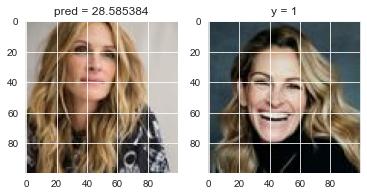

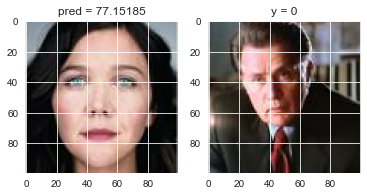

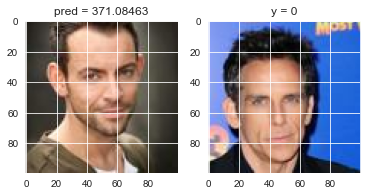

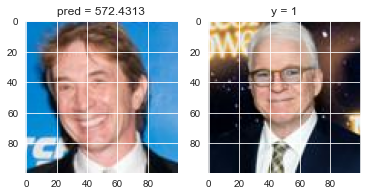

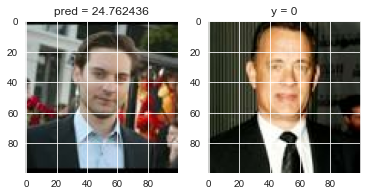

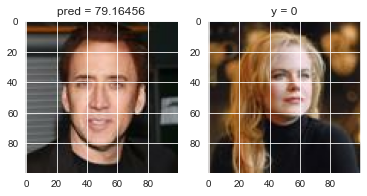

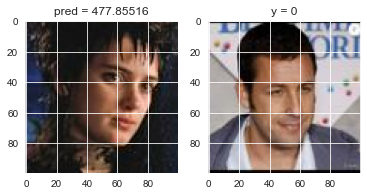

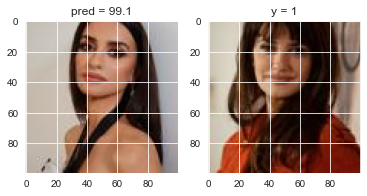

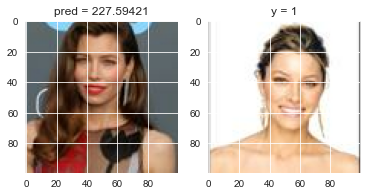

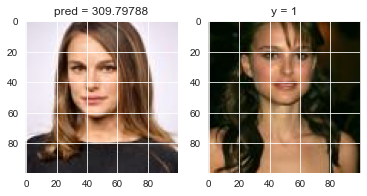

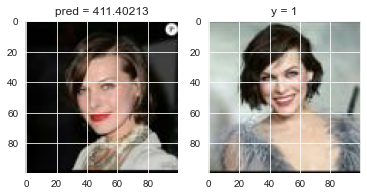

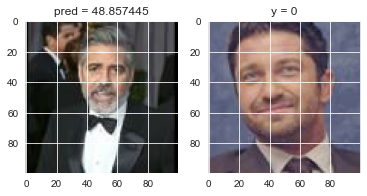

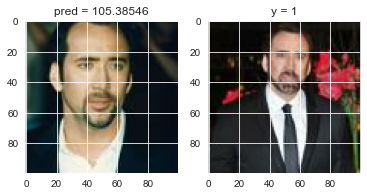

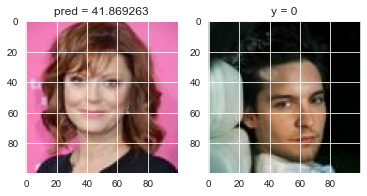

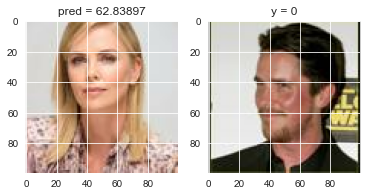

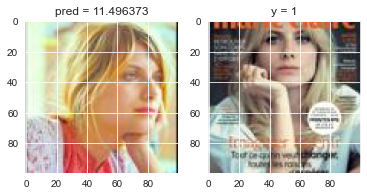

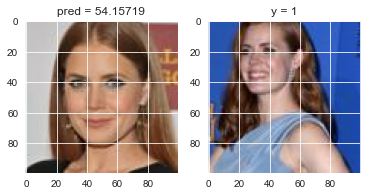

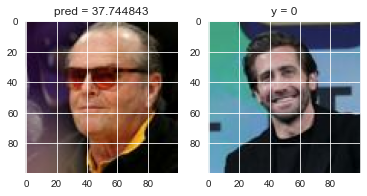

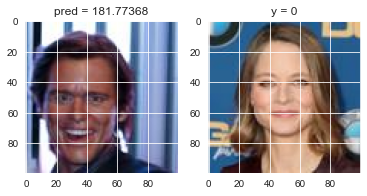

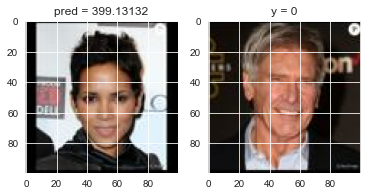

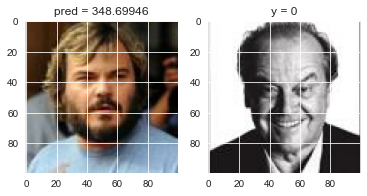

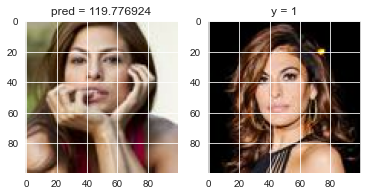

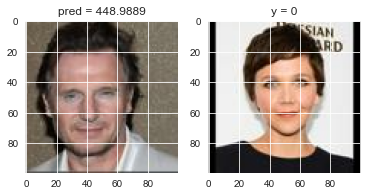

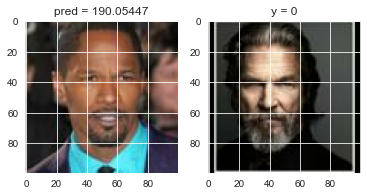

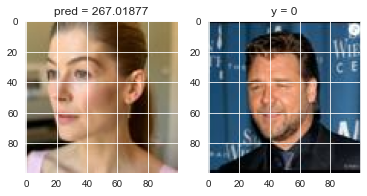

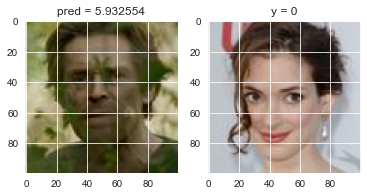

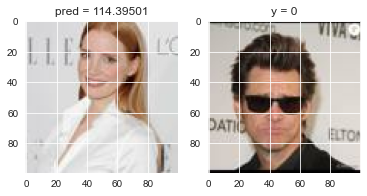

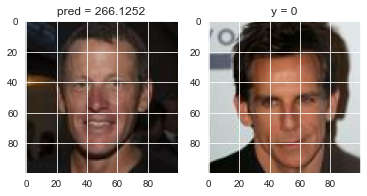

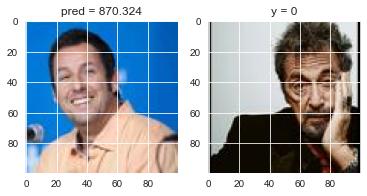

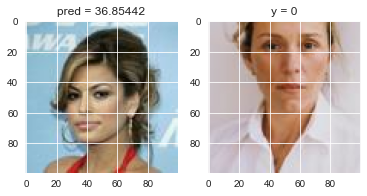

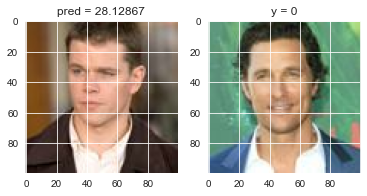

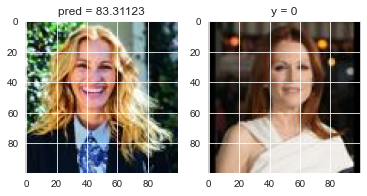

0.6875

In [31]:
#@title Точность сети
iter_test = iter(train_gen)
(a, b), y = next(iter_test)
y = y.numpy().ravel()
pred = siam.predict([a, b]).ravel()
count_true = 0
bias = 500
for i in range(len(y)):
    count_true += (y[i] == 1 and pred[i] >= bias) or (y[i] == 0 and pred[i] < bias)
    plt.subplot(121)
    plt.title('pred = %s' % pred[i])
    plt.imshow(a[i])
    plt.subplot(122)
    plt.imshow(b[i])
    plt.title('y = %s' % int(y[i]))
    plt.show()
    
count_true/len(y)